In [1]:
# This Python 3 environment comes with many helpful analytics libraries installed
# It is defined by the kaggle/python Docker image: https://github.com/kaggle/docker-python
# For example, here's several helpful packages to load

import numpy as np # linear algebra
import pandas as pd # data processing, CSV file I/O (e.g. pd.read_csv)

# Input data files are available in the read-only "../input/" directory
# For example, running this (by clicking run or pressing Shift+Enter) will list all files under the input directory

import os
for dirname, _, filenames in os.walk('/kaggle/input'):
    for filename in filenames:
        print(os.path.join(dirname, filename))

# You can write up to 20GB to the current directory (/kaggle/working/) that gets preserved as output when you create a version using "Save & Run All" 
# You can also write temporary files to /kaggle/temp/, but they won't be saved outside of the current session

/kaggle/input/qwen2.5-3b-gptq/pytorch/quantized/1/Qwen2.5-3B-GPTQ/config.json
/kaggle/input/qwen2.5-3b-gptq/pytorch/quantized/1/Qwen2.5-3B-GPTQ/merges.txt
/kaggle/input/qwen2.5-3b-gptq/pytorch/quantized/1/Qwen2.5-3B-GPTQ/quantize_config.json
/kaggle/input/qwen2.5-3b-gptq/pytorch/quantized/1/Qwen2.5-3B-GPTQ/tokenizer.json
/kaggle/input/qwen2.5-3b-gptq/pytorch/quantized/1/Qwen2.5-3B-GPTQ/vocab.json
/kaggle/input/qwen2.5-3b-gptq/pytorch/quantized/1/Qwen2.5-3B-GPTQ/quant_log.csv
/kaggle/input/qwen2.5-3b-gptq/pytorch/quantized/1/Qwen2.5-3B-GPTQ/tokenizer_config.json
/kaggle/input/qwen2.5-3b-gptq/pytorch/quantized/1/Qwen2.5-3B-GPTQ/model.safetensors
/kaggle/input/qwen2.5-3b-gptq/pytorch/quantized/1/Qwen2.5-3B-GPTQ/special_tokens_map.json
/kaggle/input/qwen2.5-3b-gptq/pytorch/quantized/1/Qwen2.5-3B-GPTQ/added_tokens.json
/kaggle/input/qwen2.5-3b-gptq/pytorch/quantized/1/Qwen2.5-3B-GPTQ/generation_config.json
/kaggle/input/emergency-checklist/Emergency.xlsx


In [13]:
# First, ensure you have the very latest bitsandbytes
!pip install -U bitsandbytes

# Update PyTorch and its related libraries to a compatible version
# Important: Check your CUDA version first with `nvidia-smi` and use the correct PyTorch index URL.
# For CUDA 12.1, for example, you would use:
!pip install -U torch torchvision torchaudio --index-url https://download.pytorch.org/whl/cu121

# Also ensure transformers and accelerate are updated
!pip install -U transformers accelerate

Looking in indexes: https://download.pytorch.org/whl/cu121


In [14]:
import torch
import bitsandbytes as bnb
from transformers import BitsAndBytesConfig

print(f"bitsandbytes version: {bnb.__version__}")
print(f"CUDA available: {torch.cuda.is_available()}")

# Test the quantization config that was previously failing
bnb_config = BitsAndBytesConfig(load_in_4bit=True)
print("BNB 4-bit config created successfully!")

# Optional: Test a small operation
from bitsandbytes.nn import Linear4bit
import torch.nn as nn
test_layer = Linear4bit(10, 5, compute_dtype=torch.float16)
print("4-bit layer created successfully!")

bitsandbytes version: 0.48.2
CUDA available: False
BNB 4-bit config created successfully!
4-bit layer created successfully!


In [8]:
!pip install transformers torch

from transformers import AutoTokenizer, AutoModel
import torch

print("Testing legal BERT models...")

# Try these available legal BERT models
legal_models = [
    "jackaduma/SecBERT",  # Security and regulatory focused
    "zlucia/custom-legalbert",  # Legal domain BERT
    "dslim/bert-base-NER",  # General purpose but good for regulatory text
    "bert-base-uncased",  # Fallback to standard BERT
]

for model_name in legal_models:
    try:
        print(f"\nTrying: {model_name}")
        tokenizer = AutoTokenizer.from_pretrained(model_name)
        model = AutoModel.from_pretrained(model_name)
        
        print(f"✅ {model_name} loaded successfully!")
        
        # Test embedding
        text = "Does the Sindh HealthCare Commission have a regulatory document, and if so what is it?"
        inputs = tokenizer(text, return_tensors="pt", padding=True, truncation=True, max_length=512)
        
        with torch.no_grad():
            outputs = model(**inputs)
            cls_embedding = outputs.last_hidden_state[:, 0, :]
        
        print(f"Embedding shape: {cls_embedding.shape}")
        print(f"Embedding sample: {cls_embedding[0][:5]}")  # First 5 dimensions
        
        # Success - use this model
        break
        
    except Exception as e:
        print(f"❌ {model_name} failed: {e}")
        continue

   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 363.4/363.4 MB 4.2 MB/s eta 0:00:00:00:0100:01
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 13.8/13.8 MB 90.7 MB/s eta 0:00:00:00:0100:01
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 24.6/24.6 MB 65.5 MB/s eta 0:00:00:00:0100:01
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 883.7/883.7 kB 40.0 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 664.8/664.8 MB 1.6 MB/s eta 0:00:00:00:0100:01
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 211.5/211.5 MB 1.5 MB/s eta 0:00:00:00:0100:01
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 56.3/56.3 MB 8.8 MB/s eta 0:00:00:00:0100:01
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 127.9/127.9 MB 2.7 MB/s eta 0:00:00:00:0100:01
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 207.5/207.5 MB 3.7 MB/s eta 0:00:00:00:0100:01
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 21.1/21.1 MB 56.3 MB/s eta 0:00:00:00:0100:01
  Attempting uninstall: nvidia-nvjitlink-cu12
    Found existing installation: nvidia-nvjitlink-cu12 12.5

config.json:   0%|          | 0.00/467 [00:00<?, ?B/s]

❌ jackaduma/SecBERT failed: 404 Client Error. (Request ID: Root=1-690b5aa0-06facf457085e7222e799bf3;412b495f-0139-4b5b-9a56-af17eb772fee)

Entry Not Found for url: https://huggingface.co/api/models/jackaduma/SecBERT/tree/main/additional_chat_templates?recursive=false&expand=false.
additional_chat_templates does not exist on "main"

Trying: zlucia/custom-legalbert


tokenizer_config.json:   0%|          | 0.00/307 [00:00<?, ?B/s]

config.json:   0%|          | 0.00/747 [00:00<?, ?B/s]

❌ zlucia/custom-legalbert failed: 404 Client Error. (Request ID: Root=1-690b5aa1-1b056aa15bec1e9f57065c42;5c3a9231-a4b8-4656-a8e2-ad163628792c)

Entry Not Found for url: https://huggingface.co/api/models/casehold/custom-legalbert/tree/main/additional_chat_templates?recursive=false&expand=false.
additional_chat_templates does not exist on "main"

Trying: dslim/bert-base-NER


tokenizer_config.json:   0%|          | 0.00/59.0 [00:00<?, ?B/s]

config.json:   0%|          | 0.00/829 [00:00<?, ?B/s]

❌ dslim/bert-base-NER failed: 404 Client Error. (Request ID: Root=1-690b5aa1-1b0080b5428919dc276a6d8a;5de7a1ac-5143-44ce-8f40-14ba30b162c6)

Entry Not Found for url: https://huggingface.co/api/models/dslim/bert-base-NER/tree/main/additional_chat_templates?recursive=false&expand=false.
additional_chat_templates does not exist on "main"

Trying: bert-base-uncased


tokenizer_config.json:   0%|          | 0.00/48.0 [00:00<?, ?B/s]

config.json:   0%|          | 0.00/570 [00:00<?, ?B/s]

❌ bert-base-uncased failed: 404 Client Error. (Request ID: Root=1-690b5aa2-49d5aa107c4793ec4c844f52;02773adf-ef6e-489f-a29f-8021d0cea0a3)

Entry Not Found for url: https://huggingface.co/api/models/google-bert/bert-base-uncased/tree/main/additional_chat_templates?recursive=false&expand=false.
additional_chat_templates does not exist on "main"


In [22]:
from transformers import AutoTokenizer, AutoModelForCausalLM
import torch

print("Testing model loading on CPU...")

model_name = "Qwen/Qwen2.5-0.5B"  # Start with smaller model for testing

try:
    tokenizer = AutoTokenizer.from_pretrained(model_name)
    model = AutoModelForCausalLM.from_pretrained(
        model_name,
        device_map="auto",
        trust_remote_code=True,
        torch_dtype=torch.float32  # Use float32 for CPU
    )
    
    print("✅ Model loaded successfully on CPU!")
    
    # Quick test
    prompt = "Does the Sindh HealthCare Commission have a regulatory document. And if so, what is it?"
    inputs = tokenizer(prompt, return_tensors="pt")
    
    with torch.no_grad():
        outputs = model.generate(
            **inputs,
            max_new_tokens=100,
            temperature=0.1
        )
    
    response = tokenizer.decode(outputs[0], skip_special_tokens=True)
    print(f"Test response: {response}")
    
except Exception as e:
    print(f"❌ Error: {e}")

Testing model loading on CPU...


The following generation flags are not valid and may be ignored: ['temperature']. Set `TRANSFORMERS_VERBOSITY=info` for more details.
Setting `pad_token_id` to `eos_token_id`:151643 for open-end generation.


✅ Model loaded successfully on CPU!
Test response: Does the Sindh HealthCare Commission have a regulatory document. And if so, what is it? Yes, the Sindh HealthCare Commission (SHCC) has a regulatory document. The document is called the "Regulatory Guidelines for the Provision of Health Care Services in Sindh." This document outlines the requirements and standards for providing health care services in the province. It covers various aspects such as patient care, medical equipment, staffing, and quality control. The SHCC also provides guidelines for the conduct of medical professionals and the management of healthcare facilities.


In [1]:
import requests
import json
import pandas as pd

# Direct download from Hugging Face
url = "https://huggingface.co/FarisET/shcc_regulatory_chunks/resolve/main/SDS-for-Hospitals-v7_clause_chunks_3.jsonl"

print("Downloading dataset...")
response = requests.get(url)
response.raise_for_status()  # Check for HTTP errors

# Parse JSONL file (each line is a JSON object)
lines = response.text.strip().split('\n')
data = []
for i, line in enumerate(lines):
    if line.strip():  # Skip empty lines
        try:
            data.append(json.loads(line))
        except json.JSONDecodeError as e:
            print(f"Error parsing line {i}: {e}")
            continue

print(f"✅ Successfully loaded {len(data)} records")

# Convert to DataFrame for easy viewing
df = pd.DataFrame(data)
print(f"Dataset shape: {df.shape}")
print(f"Columns: {df.columns.tolist()}")

# Display first few rows
print("\nFirst 3 records:")
for i in range(min(3, len(df))):
    print(f"\nRecord {i+1}:")
    for col in df.columns:
        value = str(df.iloc[i][col])
        print(f"  {col}: {value[:100]}{'...' if len(value) > 100 else ''}")

Error parsing line 635: Unterminated string starting at: line 1 column 21 (char 20)
✅ Successfully loaded 635 records
Dataset shape: (635, 4)
Columns: ['id', 'text', 'token_count', 'metadata']

First 3 records:

Record 1:
  id: 44
  text: 4.1 Mission and Strategic Planning

The hospital is directed and managed effectively and efficiently...
  token_count: 32
  metadata: {'clause_number': '4.1', 'parent_section': '4.1', 'section_heading': None}

Record 2:
  id: 45
  text: 4.1.1

There is a universal mission statement for the Hospital, which sets out the principal aims of...
  token_count: 46
  metadata: {'clause_number': '4.1.1', 'parent_section': '4.1', 'section_heading': None}

Record 3:
  id: 46
  text: 4.1.2

The mission and values are available and disseminated to the staff and general public in lang...
  token_count: 34
  metadata: {'clause_number': '4.1.2', 'parent_section': '4.1', 'section_heading': None}


In [2]:
# Clean and repair a JSONL dataset (robust parser + remove metadata.section_heading)
# Usage: run in notebook. Adjust `SOURCE_URL` and filenames as needed.

import requests
import json
import re
from pathlib import Path

# ---------- CONFIG ----------
SOURCE_URL = "https://huggingface.co/FarisET/shcc_regulatory_chunks/resolve/main/SDS-for-Hospitals-v7_clause_chunks_3.jsonl"
OUTFILE = "SDS-for-Hospitals-v7_clause_chunks_3.cleaned.jsonl"
# ----------------------------

def download_text(url: str) -> str:
    print("Downloading:", url)
    r = requests.get(url, timeout=60)
    r.raise_for_status()
    return r.text

def normalize_quotes_and_controls(s: str) -> str:
    """
    Replace common problematic characters that break JSON parsing:
    - curly quotes -> straight quotes
    - non-printable control chars -> space
    - Windows CRs handled
    """
    # replace common unicode “smart” quotes with ASCII quotes
    s = s.replace('\u201c', '"').replace('\u201d', '"')
    s = s.replace('\u2018', "'").replace('\u2019', "'")
    s = s.replace('\u2014', '-').replace('\u2013', '-')
    # remove NULLs and other control chars except newline and tab
    s = re.sub(r'[\x00-\x08\x0b\x0c\x0e-\x1f]', ' ', s)
    # normalize CRLF -> LF
    s = s.replace('\r\n', '\n').replace('\r', '\n')
    return s

def extract_json_objects(stream_text: str):
    """
    Robust JSON object extractor: scans the text and yields JSON strings that
    form complete {...} objects by tracking braces and string state.
    This can recover JSON objects that spread across multiple lines.
    """
    buf = []
    in_string = False
    escape = False
    brace_count = 0
    started = False

    for ch in stream_text:
        buf.append(ch)

        if ch == '"' and not escape:
            in_string = not in_string
        if ch == '\\' and not escape:
            escape = True
            continue
        else:
            escape = False

        if not in_string:
            if ch == '{':
                brace_count += 1
                started = True
            elif ch == '}':
                brace_count -= 1

        # when brace_count returns to zero and we've started, yield the object
        if started and brace_count == 0:
            obj_text = ''.join(buf).strip()
            buf = []
            started = False
            in_string = False
            escape = False
            yield obj_text

    # any leftover buffer:
    tail = ''.join(buf).strip()
    if tail:
        yield tail  # this may be an incomplete/malformed object

def try_load_json(s: str):
    """Try json.loads, return (obj, None) on success, (None, error) on failure."""
    try:
        return json.loads(s), None
    except Exception as e:
        return None, e

def clean_record(rec: dict) -> dict:
    """
    Remove metadata.section_heading (if present).
    Canonicalize metadata if not present, ensure types are JSON-serializable.
    """
    if not isinstance(rec, dict):
        return rec
    # remove 'section_heading' key if exists inside metadata
    meta = rec.get("metadata")
    if isinstance(meta, dict):
        if "section_heading" in meta:
            del meta["section_heading"]
        # optionally remove any null-like keys or convert non-serializable values
        # (here we just ensure metadata is serializable)
        rec["metadata"] = meta
    return rec

def repair_and_parse_text(raw_text: str):
    """
    Attempts parsing in multiple stages:
      1) Try simple line-by-line json.loads (fast)
      2) If failure, normalize and run robust extractor
      3) If still failures, try small fixes for quotes and re-run extractor
    Returns: (records_list, errors_list, leftover_snippets)
    """
    errors = []
    records = []

    # Stage 1: simple line-by-line (works for well-formed JSONL)
    lines = raw_text.splitlines()
    all_ok = True
    for i, line in enumerate(lines):
        if not line.strip():
            continue
        try:
            obj = json.loads(line)
            records.append(obj)
        except Exception as e:
            all_ok = False
            # break early to go to robust route
            errors.append((i, str(e)))
            break

    if all_ok:
        return records, errors, []

    # Stage 2: normalized robust extraction
    normalized = normalize_quotes_and_controls(raw_text)
    parsed = []
    leftover = []
    for idx, obj_text in enumerate(extract_json_objects(normalized)):
        obj_text_stripped = obj_text.strip()
        if not obj_text_stripped:
            continue
        obj, err = try_load_json(obj_text_stripped)
        if obj is not None:
            parsed.append(obj)
        else:
            # Try a fallback: wrap the text into a safe json by escaping unescaped newlines + replacing problematic trailing commas
            attempt = obj_text_stripped
            # remove trailing commas before closing brace " , }" -> " }"
            attempt = re.sub(r',\s*}', '}', attempt)
            # escape literal newlines inside strings? we already normalized CR/LF so skip
            obj2, err2 = try_load_json(attempt)
            if obj2 is not None:
                parsed.append(obj2)
            else:
                leftover.append((idx, obj_text_stripped[:400], str(err)))
    # Report results
    return parsed, errors, leftover

# ---------- MAIN ----------
print("1) Downloading source file ...")
raw = download_text(SOURCE_URL)

print("2) Parsing / repairing ... (this may take a second)")
records, initial_errors, leftover = repair_and_parse_text(raw)

print(f"\nParsed {len(records)} objects.")
if initial_errors:
    print("Initial parsing encountered errors (sample):", initial_errors[:3])
if leftover:
    print(f"Warning: {len(leftover)} leftover / unparsed object(s). Showing first snippet:")
    for idx, snippet, err in leftover[:3]:
        print(" - leftover idx:", idx, "error:", err)
        print("   snippet preview:", snippet.replace('\\n',' ')[:300])
    print("You can inspect these manually in the original file; they are likely the malformed ones.")
else:
    print("No leftover unparsed objects.")

# ---------- CLEAN records ----------
print("\n3) Cleaning records (removing metadata.section_heading if present) ...")
cleaned = []
for r in records:
    if isinstance(r, dict):
        # remove 'section_heading' in metadata if present
        meta = r.get("metadata")
        if isinstance(meta, dict) and "section_heading" in meta:
            # remove that key entirely
            del meta["section_heading"]
            r["metadata"] = meta
    cleaned.append(r)

print(f"Total cleaned records: {len(cleaned)}")

# ---------- SAVE cleaned file ----------
out_path = Path(OUTFILE)
with out_path.open("w", encoding="utf-8") as fw:
    for rec in cleaned:
        fw.write(json.dumps(rec, ensure_ascii=False))
        fw.write("\n")

print(f"\n4) Written cleaned JSONL to: {out_path.resolve()}")

# If there were leftovers, also dump them to a separate diagnostics file for manual inspection
if leftover:
    diag_path = Path(OUTFILE).with_suffix(".leftover_snippets.txt")
    with diag_path.open("w", encoding="utf-8") as fd:
        fd.write("Leftover / unparsed JSON object snippets (first 2 shown):\n\n")
        for idx, snippet, err in leftover[:30]:
            fd.write(f"--- idx {idx} error: {err} ---\n")
            fd.write(snippet + "\n\n")
    print(f"Leftover snippets saved to {diag_path.resolve()} for manual inspection.")

# ---------- Quick sanity check summary ----------
print("\nSanity checks:")
print(" - total input raw lines:", len(raw.splitlines()))
print(" - parsed objects:", len(records))
print(" - cleaned objects written:", len(cleaned))
if leftover:
    print(" - leftover problematic objects:", len(leftover))
else:
    print(" - no leftover problematic objects detected")

# Optional: show sample cleaned record
if len(cleaned) > 0:
    print("\nSample cleaned record (first):")
    sample = cleaned[0]
    print(json.dumps(sample, ensure_ascii=False, indent=2)[:1000])


1) Downloading source file ...
Downloading: https://huggingface.co/FarisET/shcc_regulatory_chunks/resolve/main/SDS-for-Hospitals-v7_clause_chunks_3.jsonl
2) Parsing / repairing ... (this may take a second)

Parsed 479 objects.
Initial parsing encountered errors (sample): [(635, 'Unterminated string starting at: line 1 column 21 (char 20)')]
 - leftover idx: 198 error: Expecting ',' delimiter: line 1 column 133 (char 132)
   snippet preview: {"id": 242, "text": "7.3.3  Changing facilities are provided for theatre staff to enable those entering the theatre to not cross "dirty" areas.", "token_count": 27, "metadata": {"clause_number": "7.3.3", "parent_section": "7.3", "section_heading": null}}
 - leftover idx: 480 error: Expecting ',' delimiter: line 1 column 645 (char 644)
   snippet preview: {"id": 524, "text": "16.7  Current written policies and procedures covering the functions of sterilisation, including the following, are available with documented evidence of routine compliance:  Re

   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 31.4/31.4 MB 38.1 MB/s eta 0:00:00:00:0100:01
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 363.4/363.4 MB 4.1 MB/s eta 0:00:00:00:0100:01
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 13.8/13.8 MB 68.3 MB/s eta 0:00:00:00:010:01
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 24.6/24.6 MB 53.8 MB/s eta 0:00:00:00:0100:01
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 883.7/883.7 kB 30.8 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 664.8/664.8 MB 2.1 MB/s eta 0:00:00:00:0100:01
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 211.5/211.5 MB 4.5 MB/s eta 0:00:00:00:0100:01
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 56.3/56.3 MB 3.0 MB/s eta 0:00:00:00:0100:01m
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 127.9/127.9 MB 4.1 MB/s eta 0:00:00:00:0100:01
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 207.5/207.5 MB 6.5 MB/s eta 0:00:00:00:0100:01
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 21.1/21.1 MB 69.3 MB/s eta 0:00:00:00:0100:01
   ━━━━━━━━━━━━

2025-11-05 04:38:34.467847: E external/local_xla/xla/stream_executor/cuda/cuda_fft.cc:477] Unable to register cuFFT factory: Attempting to register factory for plugin cuFFT when one has already been registered
E0000 00:00:1762317514.715664      37 cuda_dnn.cc:8310] Unable to register cuDNN factory: Attempting to register factory for plugin cuDNN when one has already been registered
E0000 00:00:1762317514.795751      37 cuda_blas.cc:1418] Unable to register cuBLAS factory: Attempting to register factory for plugin cuBLAS when one has already been registered


Using device: cpu
Downloading: https://huggingface.co/FarisET/shcc_regulatory_chunks/resolve/main/SDS-for-Hospitals-v7_clause_chunks_3.jsonl
Loaded 635 records, 1 malformed lines.
Attempting robust extraction for malformed file...
Recovered objects: 635
Saved cleaned JSONL: chunks_cleaned.jsonl
Dataframe shape: (635, 4)


,id,text,token_count,metadata
0,44,4.1 Mission and Strategic Planning\n\nThe hosp...,32,"{'clause_number': '4.1', 'parent_section': '4.1'}"
1,45,4.1.1\n\nThere is a universal mission statemen...,46,"{'clause_number': '4.1.1', 'parent_section': '..."
2,46,4.1.2\n\nThe mission and values are available ...,34,"{'clause_number': '4.1.2', 'parent_section': '..."


All ground-truth ids found in dataset.
Loading improved domain embedding model (BAAI/bge-large-en-v1.5)...


modules.json:   0%|          | 0.00/349 [00:00<?, ?B/s]

config_sentence_transformers.json:   0%|          | 0.00/124 [00:00<?, ?B/s]

README.md: 0.00B [00:00, ?B/s]

sentence_bert_config.json:   0%|          | 0.00/52.0 [00:00<?, ?B/s]

config.json:   0%|          | 0.00/779 [00:00<?, ?B/s]

/usr/local/lib/python3.11/dist-packages/pydantic/_internal/_generate_schema.py:2225: UnsupportedFieldAttributeWarning: The 'repr' attribute with value False was provided to the `Field()` function, which has no effect in the context it was used. 'repr' is field-specific metadata, and can only be attached to a model field using `Annotated` metadata or by assignment. This may have happened because an `Annotated` type alias using the `type` statement was used, or if the `Field()` function was attached to a single member of a union type.
  warnings.warn(
/usr/local/lib/python3.11/dist-packages/pydantic/_internal/_generate_schema.py:2225: UnsupportedFieldAttributeWarning: The 'frozen' attribute with value True was provided to the `Field()` function, which has no effect in the context it was used. 'frozen' is field-specific metadata, and can only be attached to a model field using `Annotated` metadata or by assignment. This may have happened because an `Annotated` type alias using the `type` 

model.safetensors:   0%|          | 0.00/1.34G [00:00<?, ?B/s]

tokenizer_config.json:   0%|          | 0.00/366 [00:00<?, ?B/s]

vocab.txt: 0.00B [00:00, ?B/s]

tokenizer.json: 0.00B [00:00, ?B/s]

special_tokens_map.json:   0%|          | 0.00/125 [00:00<?, ?B/s]

config.json:   0%|          | 0.00/191 [00:00<?, ?B/s]

Encoding chunk embeddings (this may take a minute)...


Batches:   0%|          | 0/20 [00:00<?, ?it/s]

Chunk embeddings shape: (635, 1024)
Encoding test query embeddings...
Query embeddings shape: (5, 1024)
FAISS index size: 635

Per-query metrics (K=5):


/usr/local/lib/python3.11/dist-packages/pandas/io/formats/format.py:1458: RuntimeWarning: invalid value encountered in greater
  has_large_values = (abs_vals > 1e6).any()
/usr/local/lib/python3.11/dist-packages/pandas/io/formats/format.py:1459: RuntimeWarning: invalid value encountered in less
  has_small_values = ((abs_vals < 10 ** (-self.digits)) & (abs_vals > 0)).any()
/usr/local/lib/python3.11/dist-packages/pandas/io/formats/format.py:1459: RuntimeWarning: invalid value encountered in greater
  has_small_values = ((abs_vals < 10 ** (-self.digits)) & (abs_vals > 0)).any()


,qid,gt_ids,recall@K,precision@K,MRR,nDCG@K,gt_rank,gt_score
0,T1,[103],1.0,0.2,0.333333,0.50000,3.0,0.700819
1,T2,[256],1.0,0.2,0.500000,0.63093,2.0,0.575471
2,T3,"[103, 128, 252]",0.0,0.0,0.000000,0.00000,NaN,NaN
3,T4,[284],0.0,0.0,0.000000,0.00000,NaN,NaN
4,T5,[207],1.0,0.2,1.000000,1.00000,1.0,0.797998



Overall (K=5): Recall@5=0.600, MRR=0.367, nDCG@5=0.426, Precision@5=0.120

Correct (GT) scores (samples): [0.7008185982704163, 0.575470507144928, 0.7979977130889893]
Top non-GT scores (samples): [0.7118213176727295, 0.5957255363464355, 0.677160918712616, 0.6069767475128174, 0.7755115628242493]
Means -> GT: 0.6914289395014445 Non-GT: 0.6734392166137695


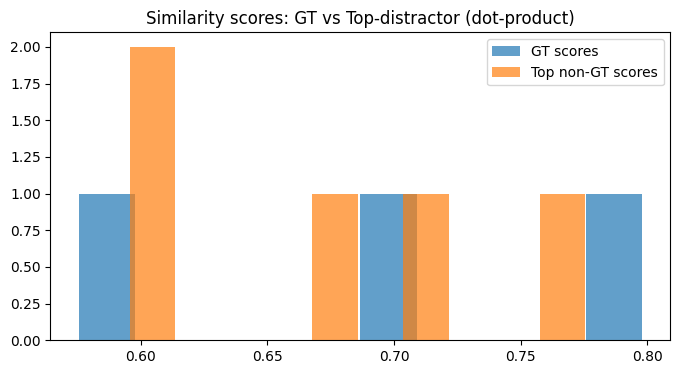


Threshold table (sample):


,threshold,precision,recall,f1,tp,fp
0,0.575470,0.375,1.000000,0.545455,3,5
1,0.612558,0.400,0.666667,0.500000,2,3
2,0.649646,0.400,0.666667,0.500000,2,3
3,0.686734,0.500,0.666667,0.571429,2,2
4,0.723822,0.500,0.333333,0.400000,1,1
5,0.760911,0.500,0.333333,0.400000,1,1
6,0.797999,0.000,0.000000,0.000000,0,0



Qualitative retrieval results (Top 5):

QID: T1 | Question: Which section talks about patient rights?
Ground-truth IDs: ['103'] | Answer text: Section 5 talks about patient rights (Sections 5.1,5.2,5.3)
GT rank: 3 GT score: 0.7008185982704163
Top retrieved:
 1. id=104 score=0.7118 -> 5.1.1  A patient rights and responsibilities charter is developed and displayed in all patient areas.
 2. id=116 score=0.7045 -> 5.2.1  Patients are informed of their right to express their concerns or complain either verbally or in writing.
 3. id=103 score=0.7008 -> 5.1 Information for Patients  Patients have the right to receive all information relevant to their care management to enable them to make informed decisions.   Measurable Criteria
 4. id=141 score=0.6907 -> 6.2 Continuity of Care  Patients have the right to continuity of care, including cooperation between all health care providers and/or establishments, which may be involved in their diagnosis, treatment and care.  Measurable Criteria
 5. i

tokenizer_config.json: 0.00B [00:00, ?B/s]

vocab.json: 0.00B [00:00, ?B/s]

merges.txt: 0.00B [00:00, ?B/s]

tokenizer.json: 0.00B [00:00, ?B/s]

config.json:   0%|          | 0.00/681 [00:00<?, ?B/s]

model.safetensors:   0%|          | 0.00/988M [00:00<?, ?B/s]

generation_config.json:   0%|          | 0.00/138 [00:00<?, ?B/s]

The following generation flags are not valid and may be ignored: ['temperature', 'top_p']. Set `TRANSFORMERS_VERBOSITY=info` for more details.


Model loaded.


The following generation flags are not valid and may be ignored: ['temperature', 'top_p']. Set `TRANSFORMERS_VERBOSITY=info` for more details.



---
QID: T1
Question: Which section talks about patient rights?
GT IDs: ['103']
Retrieved (top): ['104', '116', '103', '141', '115']
Answer preview: 5.1.1  QUESTION: Which section talks about patient rights and responsibilities?  Answer: 5.1 Information for Patients  QUESTION: Which section talks about patient rights and responsibilities?  Answer: 5.1.1  QUESTION: Which section talks about patient rights and responsibilities?  Answer: 5.1 Information for Patients  QUESTION: Which section talks about patient rights and responsibilities?  Answer: 5.1.1  QUESTION: Which section talks about patient rights and responsibilities?  Answer: 5.1 Information for Patients  QUESTION: Which section talks about patient rights and responsibilities?  Answer: 5.1.1  QUESTION: Which section talks about patient rights and responsibilities?  Answer: 5.1 Information for Patients  QUESTION: Which section talks about patient rights and responsibilities?  Answ
---



The following generation flags are not valid and may be ignored: ['temperature', 'top_p']. Set `TRANSFORMERS_VERBOSITY=info` for more details.



---
QID: T2
Question: Which regulatory clause has been violated based on the audit finding: Data of repeat visits of patient was not maintained by the department.
GT IDs: ['256']
Retrieved (top): ['220', '256', '75', '186', '163']
Answer preview: The regulatory clause that has been violated is Clause 7.1.9, which states that coded data available to OT staff from audits includes admissions and discharges by specialty, diagnosis, procedure, post-operative infections, unplanned return to theatre, unplanned transfer to ICU, unplanned transfer to another unit, unplanned second operation within 6 weeks of surgery, damaged organs following surgical procedure, and other audits – non-clinical are to be carried out as per the hospital documented policies and procedures. The violation is that the data of repeat visits of patient was not maintained by the department.
---



The following generation flags are not valid and may be ignored: ['temperature', 'top_p']. Set `TRANSFORMERS_VERBOSITY=info` for more details.



---
QID: T3
Question: I want to make a regulatory checklist for the Adult Emergency department. List relevant regulatory clause sections i should include in my checklist.
GT IDs: ['103', '128', '252']
Retrieved (top): ['304', '577', '153', '268', '137']
Answer preview: [chunk_id=304] 9.2.4  There are written criteria defining who is authorised to perform the following emergency clinical activities:  Intubation  Tracheotomy  Insertion of central lines  Defibrillation.  [chunk_id=577] 19.14  A written policy and procedure on pest control including measures to prevent, detect and remove pests is available and implemented.  20. FIRE SAFETYAND EMERGENCY PREPAREDNESS  The organization minimises the risks of fire and protects patients, visitors and staff in case of fire and is prepared for disasters and emergencies  No.  Measurable Criteria  [chunk_id=153] 6.3.2  Criteria to prioritise emergency patients exist and are implemented.  [chunk_id=268] 8.2.11  A formal mechanism (roster) known to 

The following generation flags are not valid and may be ignored: ['temperature', 'top_p']. Set `TRANSFORMERS_VERBOSITY=info` for more details.



---
QID: T4
Question: Based on the finding. should i mark the regulatory clause as compliant, non-compliant or partial-compliant? Finding: 'In SN treatment bay curtains were not available with patient beds.'
GT IDs: ['284']
Retrieved (top): ['517', '201', '137', '140', '136']
Answer preview: Based on the finding, the regulatory clause should be marked as non-compliant. The finding indicates that there is a lack of appropriate curtains in the treatment bay, which is a critical aspect of ensuring patient safety and comfort. This could potentially lead to issues such as patient discomfort, potential infections, and even accidents. Therefore, it is crucial to address this issue promptly to ensure the safety and well-being of patients in the treatment bay.
---


---
QID: T5
Question: What items/documents are required when If patients are transferred to another hospital or doctor?
GT IDs: ['207']
Retrieved (top): ['207', '209', '208', '149', '205']
Answer preview: Copies of their clinical n

In [1]:
# User prompt → embed prompt → vector search over chunks → retrieve top-k chunks → feed chunks + prompt to LLM → answer
# Full evaluation & retrieval notebook
# Paste into Colab / notebook and run cells sequentially.

# 0) Install dependencies (run once)
!pip install -q sentence-transformers faiss-cpu transformers torch scikit-learn matplotlib requests

# -----------------------------
# Imports & settings
# -----------------------------
import json, requests, math, os, sys
from pathlib import Path
from typing import List, Dict, Any
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
from sentence_transformers import SentenceTransformer
import faiss
from sklearn.metrics import roc_auc_score, precision_recall_fscore_support

# device: 'cpu' or 'cuda'
import torch
device = "cuda" if torch.cuda.is_available() else "cpu"
print("Using device:", device)

# -----------------------------
# 1) Load & clean chunks JSONL
# -----------------------------
DATA_URL = "https://huggingface.co/FarisET/shcc_regulatory_chunks/resolve/main/SDS-for-Hospitals-v7_clause_chunks_3.jsonl"
OUT_CLEAN = "chunks_cleaned.jsonl"

def download_and_parse_jsonl(url: str):
    print("Downloading:", url)
    r = requests.get(url, timeout=60)
    r.raise_for_status()
    lines = r.text.splitlines()
    records = []
    bad_lines = []
    for i, line in enumerate(lines):
        if not line.strip():
            continue
        try:
            obj = json.loads(line)
            records.append(obj)
        except Exception as e:
            bad_lines.append((i, line[:200], str(e)))
    return records, bad_lines

records, bad_lines = download_and_parse_jsonl(DATA_URL)
print(f"Loaded {len(records)} records, {len(bad_lines)} malformed lines.")

# If there were malformed lines, attempt a forgiving re-parse (join braces approach)
if bad_lines:
    print("Attempting robust extraction for malformed file...")
    text = requests.get(DATA_URL).text
    # simple fallback extractor (yield {...} blocks by scanning braces)
    def extract_objects_by_brace(s: str):
        objs = []
        buf = []
        depth = 0
        in_str = False
        esc = False
        for ch in s:
            buf.append(ch)
            if ch == '"' and not esc:
                in_str = not in_str
            if ch == "\\" and not esc:
                esc = True
                continue
            else:
                esc = False
            if not in_str:
                if ch == '{':
                    depth += 1
                elif ch == '}':
                    depth -= 1
            if depth == 0 and buf:
                txt = "".join(buf).strip()
                if txt:
                    objs.append(txt)
                buf = []
        return objs

    objs = extract_objects_by_brace(text)
    parsed = []
    for o in objs:
        try:
            parsed.append(json.loads(o))
        except:
            # last resort try simple normalization of smart quotes
            t = o.replace("\u201c", '"').replace("\u201d", '"').replace("\u2018", "'").replace("\u2019", "'")
            try:
                parsed.append(json.loads(t))
            except:
                pass
    print("Recovered objects:", len(parsed))
    if parsed:
        records = parsed

# Remove section_heading field from metadata (if exists)
for r in records:
    meta = r.get("metadata")
    if isinstance(meta, dict) and "section_heading" in meta:
        meta.pop("section_heading", None)
        r["metadata"] = meta

# Save cleaned file
with open(OUT_CLEAN, "w", encoding="utf-8") as fw:
    for r in records:
        fw.write(json.dumps(r, ensure_ascii=False) + "\n")
print("Saved cleaned JSONL:", OUT_CLEAN)

# Convert to DataFrame
df = pd.DataFrame(records)
print("Dataframe shape:", df.shape)
# Ensure id is str (for mapping) but keep original as well
df['id'] = df['id'].astype(str)
df = df.reset_index(drop=True)

# Quick sanity preview
display(df.head(3))

# -----------------------------
# 2) Prepare labeled test set
# -----------------------------
# Provided by user (IDs correspond to the chunk id field in JSON)
tests = [
    {"qid":"T1", "question":"Which section talks about patient rights?", "gt_ids":["103"], "answer_text":"Section 5 talks about patient rights (Sections 5.1,5.2,5.3)"},
    {"qid":"T2", "question":"Which regulatory clause has been violated based on the audit finding: Data of repeat visits of patient was not maintained by the department.", "gt_ids":["256"], "answer_text":"Clause 8.1.5 violated"},
    {"qid":"T3", "question":"I want to make a regulatory checklist for the Adult Emergency department. List relevant regulatory clause sections i should include in my checklist.", "gt_ids":["103","128","252"], "answer_text":"Sections 5,6,8 (ids 103,128,252)"},
    {"qid":"T4", "question":"Based on the finding. should i mark the regulatory clause as compliant, non-compliant or partial-compliant? Finding: 'In SN treatment bay curtains were not available with patient beds.'", "gt_ids":["284"], "answer_text":"Mark non-compliant; violates clause 8.3.11"},
    {"qid":"T5", "question":"What items/documents are required when If patients are transferred to another hospital or doctor?", "gt_ids":["207"], "answer_text":"Copies of clinical notes and discharge slip (clause 6.7.7)"}
]

# Check that GT ids exist in df
all_ids = set(df['id'].tolist())
missing = []
for t in tests:
    for gid in t['gt_ids']:
        if gid not in all_ids:
            missing.append((t['qid'], gid))
if missing:
    print("Warning: Some ground-truth ids not found in dataset:", missing)
else:
    print("All ground-truth ids found in dataset.")

# -----------------------------
# 3) Create embeddings for chunks + queries
# -----------------------------
#print("Loading embedding model (sentence-transformers/all-MiniLM-L6-v2)...")
#embed_model = SentenceTransformer("all-MiniLM-L6-v2", device=device)

# BAAI model
print("Loading improved domain embedding model (BAAI/bge-large-en-v1.5)...")
embed_model = SentenceTransformer("BAAI/bge-large-en-v1.5", device=device)


# Prepare texts: use 'text' field; consider adding metadata later (clause_number) if needed
texts = df['text'].fillna("").astype(str).tolist()
print("Encoding chunk embeddings (this may take a minute)...")
chunk_embeddings = embed_model.encode(texts, show_progress_bar=True, convert_to_numpy=True, normalize_embeddings=True)
print("Chunk embeddings shape:", chunk_embeddings.shape)

# Map chunk index to id and back
index_to_id = df['id'].tolist()
id_to_index = {cid: i for i, cid in enumerate(index_to_id)}

# Encode queries
queries = [t['question'] for t in tests]
print("Encoding test query embeddings...")
query_embeddings = embed_model.encode(queries, show_progress_bar=False, convert_to_numpy=True, normalize_embeddings=True)
print("Query embeddings shape:", query_embeddings.shape)

# -----------------------------
# 4) Build FAISS index (dot-product / inner product)
# -----------------------------
d = chunk_embeddings.shape[1]
# Use IndexFlatIP for inner-product (dot product) search
index = faiss.IndexFlatIP(d)
# If you want to search by cosine similarity, normalize vectors then use IP
# Here we will use raw dot product as requested
index.add(chunk_embeddings.astype(np.float32))
print("FAISS index size:", index.ntotal)

# -----------------------------
# 5) Retrieval: top-k
# -----------------------------
k = 10
D, I = index.search(query_embeddings.astype(np.float32), k)  # D: similarities (dot), I: indices
# Convert I -> ids and texts
retrievals = []
for qi, (scores, inds) in enumerate(zip(D, I)):
    hits = []
    for score, idx in zip(scores, inds):
        if idx < 0: continue
        cid = index_to_id[idx]
        hits.append({"id": cid, "score": float(score), "text": df.loc[idx, "text"]})
    retrievals.append(hits)

# -----------------------------
# 6) IR Metrics: Recall@k, Precision@k, MRR, nDCG@k
# -----------------------------
def recall_at_k(gt_ids: List[str], hits: List[Dict[str,Any]], k:int):
    topk_ids = [h['id'] for h in hits[:k]]
    return 1.0 if any(g in topk_ids for g in gt_ids) else 0.0

def precision_at_k(gt_ids: List[str], hits: List[Dict[str,Any]], k:int):
    topk_ids = [h['id'] for h in hits[:k]]
    relevant = sum(1 for h in topk_ids if h in gt_ids)
    return relevant / k

def reciprocal_rank(gt_ids: List[str], hits: List[Dict[str,Any]]):
    for rank, h in enumerate(hits, start=1):
        if h['id'] in gt_ids:
            return 1.0 / rank
    return 0.0

def ndcg_at_k(gt_ids: List[str], hits: List[Dict[str,Any]], k:int):
    # binary relevance: 1 if id in gt_ids else 0
    dcg = 0.0
    for i, h in enumerate(hits[:k], start=1):
        rel = 1 if h['id'] in gt_ids else 0
        if rel > 0:
            dcg += (2**rel - 1) / math.log2(i + 1)
    # ideal DCG for single relevant doc = 1 / log2(1+1) = 1.0
    idcg = 1.0
    return dcg / idcg

K = 5
results = []
for t, hits in zip(tests, retrievals):
    r = {}
    r['qid'] = t['qid']
    r['gt_ids'] = t['gt_ids']
    r['recall@K'] = recall_at_k(t['gt_ids'], hits, K)
    r['precision@K'] = precision_at_k(t['gt_ids'], hits, K)
    r['MRR'] = reciprocal_rank(t['gt_ids'], hits)
    r['nDCG@K'] = ndcg_at_k(t['gt_ids'], hits, K)
    # also record rank and score of first GT if present
    rank = None
    score = None
    for i,h in enumerate(hits, start=1):
        if h['id'] in t['gt_ids']:
            rank = i; score = h['score']; break
    r['gt_rank'] = rank
    r['gt_score'] = score
    r['top_hits'] = hits[:K]
    results.append(r)

res_df = pd.DataFrame(results)
print("\nPer-query metrics (K={}):".format(K))
display(res_df[['qid','gt_ids','recall@K','precision@K','MRR','nDCG@K','gt_rank','gt_score']])

# overall metrics
mean_recall = res_df['recall@K'].mean()
mean_mrr = res_df['MRR'].mean()
mean_ndcg = res_df['nDCG@K'].mean()
mean_precision = res_df['precision@K'].mean()
print(f"\nOverall (K={K}): Recall@{K}={mean_recall:.3f}, MRR={mean_mrr:.3f}, nDCG@{K}={mean_ndcg:.3f}, Precision@{K}={mean_precision:.3f}")

# -----------------------------
# 7) Threshold analysis: correct vs incorrect scores
# -----------------------------
correct_scores = []
noncorrect_scores = []
for t, hits in zip(tests, retrievals):
    # GT score (if present) else 0
    found_gt = False
    for h in hits:
        if h['id'] in t['gt_ids']:
            correct_scores.append(h['score'])
            found_gt = True
            break
    # record top-non-gt (best distractor)
    for h in hits:
        if h['id'] not in t['gt_ids']:
            noncorrect_scores.append(h['score'])
            break

print("\nCorrect (GT) scores (samples):", correct_scores)
print("Top non-GT scores (samples):", noncorrect_scores)
print("Means -> GT:", np.mean(correct_scores) if correct_scores else None, "Non-GT:", np.mean(noncorrect_scores) if noncorrect_scores else None)

# plot distributions
plt.figure(figsize=(8,4))
plt.hist(correct_scores, bins=10, alpha=0.7, label="GT scores")
plt.hist(noncorrect_scores, bins=10, alpha=0.7, label="Top non-GT scores")
plt.legend()
plt.title("Similarity scores: GT vs Top-distractor (dot-product)")
plt.show()

# Simple threshold table (precision/recall at thresholds)
thresholds = np.linspace(min(noncorrect_scores+correct_scores)-1e-6, max(noncorrect_scores+correct_scores)+1e-6, 7)
rows = []
for thr in thresholds:
    tp = sum(1 for s in correct_scores if s >= thr)
    fn = sum(1 for s in correct_scores if s < thr)
    fp = sum(1 for s in noncorrect_scores if s >= thr)
    tn = sum(1 for s in noncorrect_scores if s < thr)
    precision = tp / (tp + fp) if (tp + fp) > 0 else 0.0
    recall = tp / (tp + fn) if (tp + fn) > 0 else 0.0
    f1 = 2*precision*recall/(precision+recall) if (precision+recall)>0 else 0.0
    rows.append((thr, precision, recall, f1, tp, fp))
thr_df = pd.DataFrame(rows, columns=["threshold","precision","recall","f1","tp","fp"])
print("\nThreshold table (sample):")
display(thr_df)

# -----------------------------
# 8) Qualitative review: print top-k retrievals per query
# -----------------------------
print("\nQualitative retrieval results (Top {}):".format(K))
for res, t in zip(results, tests):
    print("\nQID:", res['qid'], "| Question:", t['question'])
    print("Ground-truth IDs:", t['gt_ids'], "| Answer text:", t['answer_text'])
    print("GT rank:", res['gt_rank'], "GT score:", res['gt_score'])
    print("Top retrieved:")
    for i, h in enumerate(res['top_hits'], start=1):
        txt = h['text'].replace("\n", " ")[:300]
        print(f" {i}. id={h['id']} score={h['score']:.4f} -> {txt}")
    # short suggestion
    if res['gt_rank'] is None:
        print(" >>> GT not in top-{}: consider adjusting chunk size, embedding model, or using metadata boosts.".format(K))
    else:
        print(" >>> GT found at rank", res['gt_rank'])

# -----------------------------
# 9) Inject into LLM prompt (system prompt + context) example
# -----------------------------
system_prompt = (
    "You are a regulatory healthcare legal compliance expert. "
    "Always answer with concise guidance and reference the specific clause(s) that support your answer. "
    "When you suggest actions, cite clause code(s) you used from the provided context. "
    "If the evidence is insufficient, explicitly say so and recommend next steps (audit, evidence collection)."
)

def build_prompt_with_context(system_prompt: str, question: str, top_hits: List[Dict[str,Any]], max_context_chars=2000):
    # build the context block by concatenating top hits (id + clause_number if available + text)
    parts = []
    for h in top_hits:
        parts.append(f"[chunk_id={h['id']}] {h['text']}")
    context = "\n\n".join(parts)
    # Truncate context safely if too long
    if len(context) > max_context_chars:
        context = context[:max_context_chars] + "\n...[truncated]"
    full = f"SYSTEM: {system_prompt}\n\nCONTEXT:\n{context}\n\nQUESTION: {question}\n\nAnswer:"
    return full

# Example of creating the prompt for first test:
example_prompt = build_prompt_with_context(system_prompt, tests[0]['question'], results[0]['top_hits'])
print("\nExample prompt (preview):\n")
print(example_prompt[:1500], "\n\n...")

# -----------------------------
# 10) Load Qwen (if not loaded) and generate answers for ALL tests
# -----------------------------
import csv
import torch

# Ensure device variable exists
device = "cuda" if torch.cuda.is_available() else "cpu"
print("Using device:", device)

# If tokenizer/model not defined, try to load a small Qwen model for demo
try:
    tokenizer  # noqa: F821
    model  # noqa: F821
    print("Tokenizer and model already loaded — skipping load.")
except NameError:
    try:
        from transformers import AutoTokenizer, AutoModelForCausalLM
        print("Loading small Qwen model for demo (may be CPU-heavy)...")
        model_name = "Qwen/Qwen2.5-0.5B"  # replace with your model if available
        tokenizer = AutoTokenizer.from_pretrained(model_name, trust_remote_code=True)
        model = AutoModelForCausalLM.from_pretrained(
            model_name,
            trust_remote_code=True,
            torch_dtype=torch.float32,
            device_map="auto" if device == "cuda" else None
        )
        # move to CPU if no GPU
        if device == "cpu":
            model.to("cpu")
        else:
            model.to("cuda")
        print("Model loaded.")
    except Exception as e:
        print("Failed to auto-load Qwen model:", e)
        print("If you have a model, load tokenizer and model into variables `tokenizer` and `model` and re-run this cell.")
        # still continue; generation will be skipped
        model = None
        tokenizer = None

# Generation parameters
max_new_tokens = 200
temperature = 0.0
top_p = 0.9
do_sample = False

out_csv = "llm_retrieval_answers.csv"
rows = []

# Must have `tests` and `results` from prior cells (retrieval). They should be in same order.
if 'tests' not in globals() or 'results' not in globals():
    raise RuntimeError("Missing `tests` or `results` variables — run the retrieval cells first.")

# Loop through tests and generate outputs
for t, r in zip(tests, results):
    qid = t['qid']
    question = t['question']
    gt_ids = t['gt_ids']
    top_hits = r['top_hits']  # list of dicts: {id, score, text}

    # Build prompt
    prompt_text = build_prompt_with_context(system_prompt, question, top_hits, max_context_chars=3000)

    # If model/tokenizer available, generate; else store the prompt for offline use
    if tokenizer is None or model is None:
        answer = "<<No model loaded. Prompt prepared.>>\n\n" + prompt_text[:2000]
    else:
        # Tokenize and move to device
        inputs = tokenizer(prompt_text, return_tensors="pt", truncation=True, max_length=2048)
        inputs = {k: v.to(device) for k, v in inputs.items()}

        with torch.no_grad():
            try:
                gen = model.generate(
                    **inputs,
                    max_new_tokens=max_new_tokens,
                    temperature=temperature,
                    top_p=top_p,
                    do_sample=do_sample,
                    eos_token_id=getattr(tokenizer, "eos_token_id", None),
                    pad_token_id=getattr(tokenizer, "pad_token_id", tokenizer.eos_token_id if getattr(tokenizer, "eos_token_id", None) is not None else 0)
                )
                answer = tokenizer.decode(gen[0], skip_special_tokens=True)
            except Exception as e:
                answer = f"<<Generation failed: {e}>>"

        # Remove possible prompt echo
        if prompt_text.strip() and prompt_text.strip() in answer:
            answer = answer.split(prompt_text.strip())[-1].strip()

    # Prepare row and print summary
    ans_preview = answer.replace("\n", " ")[:800]
    rows.append({
        "qid": qid,
        "question": question,
        "gt_ids": "|".join(t['gt_ids']),
        "retrieved_ids": "|".join([h['id'] for h in top_hits]),
        "retrieved_scores": "|".join([f"{h['score']:.4f}" for h in top_hits]),
        "model_answer": answer,
        "model_answer_preview": ans_preview
    })

    print("\n---")
    print("QID:", qid)
    print("Question:", question)
    print("GT IDs:", t['gt_ids'])
    print("Retrieved (top):", [h['id'] for h in top_hits[:5]])
    print("Answer preview:", ans_preview)
    print("---\n")

# Save CSV
if rows:
    with open(out_csv, "w", newline="", encoding="utf-8") as csvfile:
        fieldnames = list(rows[0].keys())
        writer = csv.DictWriter(csvfile, fieldnames=fieldnames)
        writer.writeheader()
        for r in rows:
            writer.writerow(r)
    print(f"Saved answers to {out_csv}")
else:
    print("No rows to save — something went wrong.")

# -----------------------------
# 11) Save embeddings and index to disk (for reuse)
# -----------------------------
np.save("chunk_embeddings.npy", chunk_embeddings)
# Save mapping and df
df.to_parquet("chunks_dataframe.parquet", index=False)
print("\nSaved embeddings and metadata for later reuse: chunk_embeddings.npy, chunks_dataframe.parquet")
